# Rational
<center>Development for a fitting function (greedy+linear based on mvpolyfit and gmvpfit) that handles rational fucntions</center>

In [1]:
# Low-level import 
from numpy import *
from numpy.linalg import pinv,lstsq
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import *
#
import positive
from positive import *

## Package Development (positive/learning.py)

In [11]:
################################################################################
h = 3
Q = 15
x = h*linspace(-1,1,Q) 
y = h*linspace(-1,1,Q) 
X,Y = meshgrid(x,y)
# X += np.random.random( X.shape )-0.5
# Y += np.random.random( X.shape )-0.5
zfun = lambda xx,yy: 50 + (1.0 + xx*yy) / ( 1.0 + xx**2 + yy**2 )
np.random.seed(42)
ns = 0.1*(np.random.random( X.shape )-0.5)
Z = zfun(X,Y) + ns
numerator_symbols, denominator_symbols = ['K','01'], ['00','11'] 
domain,scalar_range = ndflatten( [X,Y], Z )
################################################################################

In [12]:
from positive.learning import mvrfit
foo = mvrfit( domain, scalar_range, numerator_symbols, denominator_symbols, verbose=True )

(__fit__)>> Exiting because z is small


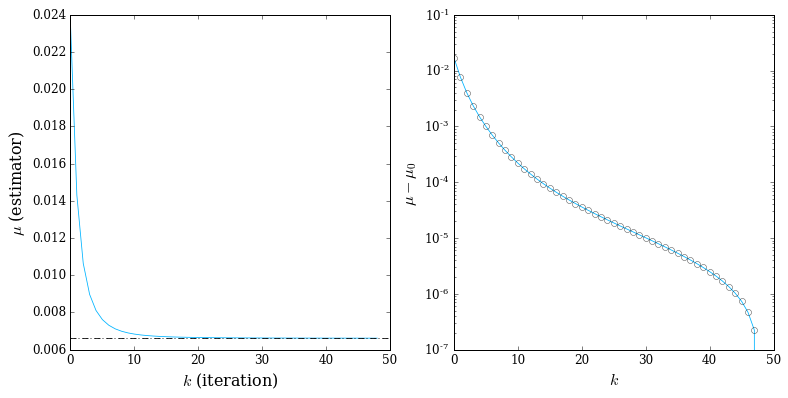

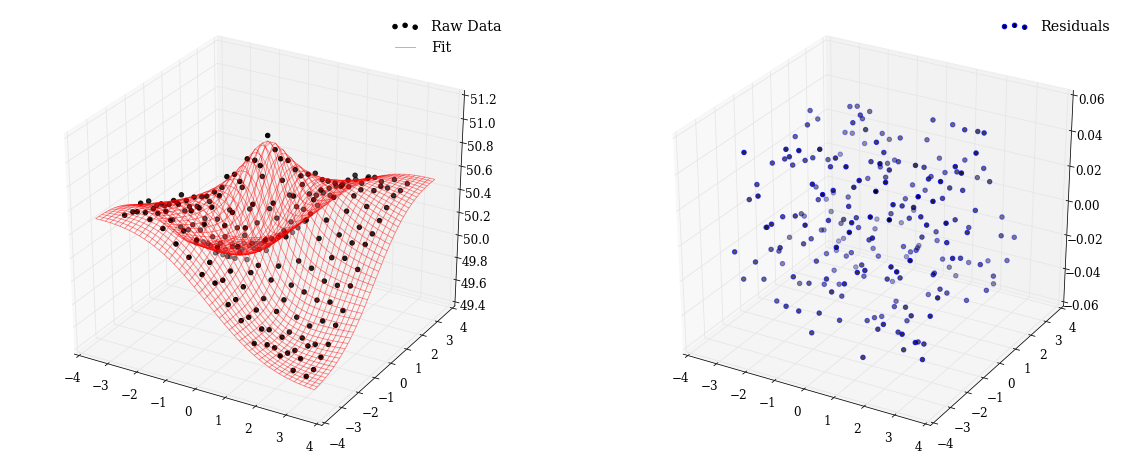

In [13]:
foo.plot()

In [27]:
print foo.__str_python__(precision=3)

f = lambda x0,x1: 5.020e+01  +  3.599e-01 * (  -5.576e-01*(x0*x0) + 2.727e+00*(x0*x1) + -5.512e-01*(x1*x1) + 2.220e+00 ) / ( 1.0 +  9.853e-01*(x0*x0) + 9.864e-01*(x1*x1) )
